# Multifidely Data Fusion (MFGP)
In this notebook, we explain how to build a multifidelity gaussian process surrogate using our *MFGP* library. For this setup, we are going to going to use artificial functions. Firstly, we will provide an example of one dimensional problem. After that, we provide an example for 4-d case.

In [1]:
import numpy as np
import mfgp.models as models
from mfgp.adaptation_maximizers import ScipyDirectMaximizer
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
np.random.seed(10)

2022-10-26 13:49:15.487172: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-26 13:49:15.487215: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## One dimensional case test case
We consider a case as discussed in [1](https://royalsocietypublishing.org/doi/10.1098/rspa.2016.0751) .
$$f_l(x) = sin(8 \pi x)$$
$$f_h(x) = (x-\sqrt{2})sin ^2 (8 \pi x)

In [2]:
def lf(x):
    return np.sin(8 * np.pi*x)

def hf(x):
    return (x-np.sqrt(2)) * (np.sin(8 * np.pi * x))**2

lower, upper = 0, 1

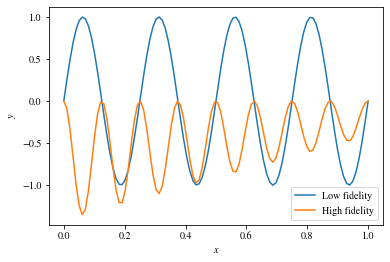

In [3]:
def plot1d(func, label, lower=0, upper=1):
    x = np.linspace(lower, upper, 100)
    y = func(x)
    plt.plot(x, y, label=label)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')

plot1d(lf, "Low fidelity")
plot1d(hf, "High fidelity")
plt.legend()
plt.show()

We can observe from the plot that the low fidelity only models the oscillation. We need to learn other features of high fidelity model.


We create training and testing data.
We start with just 5 training points.

In [4]:
num_train, num_test = 5, 100
X_train, X_test = np.random.uniform(lower, upper, (num_train, 1)), np.random.uniform(lower, upper, (num_test, 1))
Y_train, Y_test = hf(X_train), hf(X_test)

The basic frameworks are discussed/motivated from [1](https://royalsocietypublishing.org/doi/10.1098/rspa.2016.0751), [2](https://royalsocietypublishing.org/doi/10.1098/rsfs.2018.0083)
There are three types of multifidelity gaussian process frameworks that are implemented in the library:
1. NARGP (Non-linear Auto Regressive Gaussian Process) [1](https://royalsocietypublishing.org/doi/10.1098/rspa.2016.0751)
2. GPDF (Gaussian Process surrogate with Derivative Fusion) [2](https://royalsocietypublishing.org/doi/10.1098/rsfs.2018.0083)
3. GPDF-C (Gaussian Process surrogate with Derivative Fusion using Composite kernel) : This uses the parameters as described in [2](https://royalsocietypublishing.org/doi/10.1098/rsfs.2018.0083) with the kernel motivated from Taylor expansion. We are currently working on the the corresponding paper.

For all the cases we can have two setups:
1. Assume that the low-fidelity function is infinitel cheap to compute when compared to high fidelity function. So, there is no need create any surrogate for low-fidelity function. This can be controlled by modifying the variable *surrogate_lowest_fidelity=False*.
2. When low-fidelity function has considerable computational effort, then we need to create surrogate for low-fidelity. This can be done by modifying the variable *surrogate_lowest_fidelity=True*.

The code is not just designed for 2 fidelities. It can work for more than 2 fidelities too. But, the quality of results depends on quality of medium fidelity surrogates.

In the example, we use NARGP where we assume that low fidelity model is infintely cheap as compared to high fidelity function.

In [5]:
dim = 1
# Create a list of functions starting from lowest fidelity and then movin up to higher fidelities
f_list = [lf, hf]  
# Then create a list of points which will serve a starting points for training GP for each level of fidelity
# If you do not want to create surrogate of the low fidelity model, then assign it as None (any dummy object)
init_X = [None, X_train] 
# Lower bound and upper bound should be in form of list
lower_bound, upper_bound = [0], [1]
# Create the object of NARGP_General  
gp_surrogate = models.NARGP_General(dim, f_list, init_X, lower_bound, upper_bound, ScipyDirectMaximizer, surrogate_lowest_fidelity=False)

2022-10-26 13:49:20.399902: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-26 13:49:20.399928: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-26 13:49:20.399947: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mustang-system): /proc/driver/nvidia/version does not exist
2022-10-26 13:49:20.400738: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-26 13:49:20.482841: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequence

In [6]:
# We can obtain the mean square error as following
gp_surrogate.get_mse(X_test, Y_test)

0.29919283223250187

In [7]:
def plot_1d_gp(gp_obj, lower=0, upper=1):
    x = np.linspace(lower, upper, 100)
    mean, var = gp_surrogate.predict(x[:, None])
    std = np.sqrt(var).ravel()
    plt.plot(x, mean.ravel(), label='Predicted mean')
    plt.fill_between(x, mean.ravel()-std, mean.ravel()+std, label='Uncertainity', alpha=.4)

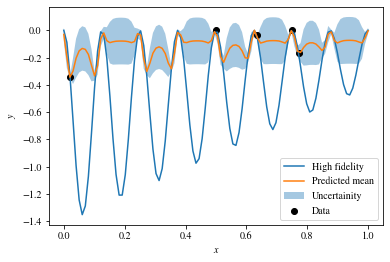

In [8]:
plot1d(hf, "High fidelity")
plot_1d_gp(gp_surrogate)
plt.scatter(X_train, Y_train, color='black', label="Data")
plt.legend()
plt.show()

We observe that the fit in the model is not satisfactory. We need to add more data points. We add the new data points by adaptively choosing points. For that we define an acquisition function and choose the point with highest value of acquisition function. Acquisition function represents the gain of information due to addition of point in the observed data. We greedily add points which has maximum gain in information. We have implemented two types of acquisition function 

In [9]:
points_per_fidelity = np.array([1]) # This is used when there are multiple heirarchies of models
num_adapt = 5 # Numer of adpation steps
gp_surrogate.adapt(10, points_per_fidelity)

Step number  1
Fidelity 1


/home/mustang/work/multifidelity-datafusion-GPs/mfgp/adaptation_maximizers/scipy_opt.py:19: OptimizeWarning: Unknown solver options: maxfev
  res = minimize(function, x0, bounds=Bounds(lower_bound, upper_bound), method=method, options={'maxfev':maxiter})


0 [0.6875922] [-0.02925435]
1 [0.56250034] [-0.02624379]
2 [0.31246865] [-0.02630832]
3 [0.06243534] [-0.02649137]
4 [0.56250032] [-0.02624379]
5 [0.43742041] [-0.02925301]
Selected point is [0.6875922] with acquisition function -0.029254350666671307
Step number  2
Fidelity 1
0 [0.56248424] [-0.0317639]
1 [0.61209626] [-0.00037635]
2 [0.18129676] [-0.01277762]
3 [0.06241114] [-0.03460346]
4 [0.31244522] [-0.03272776]
5 [0.18129813] [-0.01277762]
Selected point is [0.06241114] with acquisition function -0.0346034576170019
Step number  3
Fidelity 1
0 [0.15558405] [-0.04110119]
1 [0.90524467] [-0.03300762]
2 [0.21936961] [-0.03888267]
3 [0.21936959] [-0.03888267]
4 [0.81367327] [-0.01603032]
5 [0.28588936] [-0.00768791]
Selected point is [0.15558405] with acquisition function -0.04110118890301573
Step number  4
Fidelity 1
0 [0.83492705] [-0.01712357]
1 [0.47593657] [-0.00384721]
2 [0.56449571] [-0.00739406]
3 [0.08982807] [-0.01197187]
4 [0.18668063] [-0.00902668]
5 [0.6535079] [-0.008018

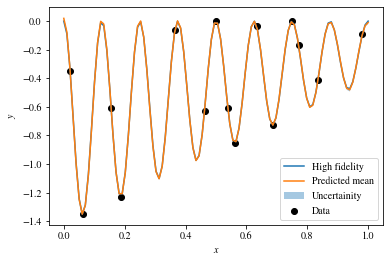

In [10]:
plot1d(hf, "High fidelity")
plot_1d_gp(gp_surrogate)
plt.scatter(gp_surrogate.models[-1].hf_X, hf(gp_surrogate.models[-1].hf_X), color='black', label="Data")
plt.legend()
plt.show()

You can also calculate derivate of the surrogate as following:

In [18]:
predicted_mean, predictive_var, predicted_grad = gp_surrogate.predict_grad(X_test)

# analytical definition of high fidelity function
def hf_derivative(x):
    return (np.sin(8*np.pi*x))**2 + (16 * np.pi * (x - np.sqrt(2)) * np.sin(8*np.pi*x) * np.cos(8 * np.pi * x))

actual_grad = hf_derivative(X_test)

print("Relative Error:", np.linalg.norm((predicted_grad - actual_grad)/(len(X_test)*actual_grad)))

Error: 0.003635509107065695
